In [99]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('train.csv')
df.head()

test_1 = pd.read_csv('test.csv')

In [100]:
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

Guest_Popularity_percentage    19.470667
Episode_Length_minutes         11.612400
Number_of_Ads                   0.000133
id                              0.000000
Episode_Title                   0.000000
Podcast_Name                    0.000000
Genre                           0.000000
Host_Popularity_percentage      0.000000
Publication_Time                0.000000
Publication_Day                 0.000000
Episode_Sentiment               0.000000
Listening_Time_minutes          0.000000
dtype: float64

In [101]:
df['Podcast_Episode'] = df['Podcast_Name'] + ' - ' + df['Episode_Title']
df['Podcast_Episode'].unique()

df = df.drop('id', axis=1)
#new features
df['Guest_Popularity_missing'] = df['Guest_Popularity_percentage'].isnull().astype(int)
df['Episode_Length_minutes_missing'] = df['Episode_Length_minutes'].isnull().astype(int)
df['Guest_Popularity_missing_x_length'] = df['Guest_Popularity_missing'] * df['Episode_Length_minutes']



#
df_test = df.drop(['Podcast_Name', 'Episode_Title'], axis=1)

split

In [102]:
y = df_test['Listening_Time_minutes']
X = df_test.drop('Listening_Time_minutes', axis=1)

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
categorical_cols = [
    'Podcast_Episode', 'Publication_Time', 'Genre',
    'Publication_Day', 'Episode_Sentiment', 'Episode_Length_minutes_missing', 'Guest_Popularity_missing'
]

for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


In [105]:
X_train['Number_of_Ads'] = X_train['Number_of_Ads'].fillna(X_train['Number_of_Ads'].median())
X_test['Number_of_Ads'] = X_test['Number_of_Ads'].fillna(X_test['Number_of_Ads'].median())

X_train['Guest_Popularity_percentage'] = X_train['Guest_Popularity_percentage'].fillna(X_train['Guest_Popularity_percentage'].median())
X_test['Guest_Popularity_percentage'] = X_test['Guest_Popularity_percentage'].fillna(X_test['Guest_Popularity_percentage'].median())

X_train['Episode_Length_minutes'] = X_train['Episode_Length_minutes'].fillna(X_train['Episode_Length_minutes'].median())
X_test['Episode_Length_minutes'] = X_test['Episode_Length_minutes'].fillna(X_test['Episode_Length_minutes'].median())



In [106]:
# Step 1: Compute target means from training data only
temp = X_train.copy()
temp['target'] = y_train
target_map = temp.groupby('Podcast_Episode')['target'].mean()

# Step 2: Encode train set using the target_map
X_train['Podcast_Episode_encoded'] = X_train['Podcast_Episode'].map(target_map)

# Step 3: Encode test set using the same mapping
X_test['Podcast_Episode_encoded'] = X_test['Podcast_Episode'].map(target_map)

# Step 4 (important): Fill unknown Podcast_Episodes in test with global mean
X_test['Podcast_Episode_encoded'] = X_test['Podcast_Episode_encoded'].astype(float)
X_test['Podcast_Episode_encoded'] = X_test['Podcast_Episode_encoded'].fillna(y_train.mean())

C:\Users\pc\AppData\Local\Temp\ipykernel_72604\4052079471.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_map = temp.groupby('Podcast_Episode')['target'].mean()


In [107]:
X_train

,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Podcast_Episode,Guest_Popularity_missing,Episode_Length_minutes_missing,Guest_Popularity_missing_x_length,Podcast_Episode_encoded
453635,94.30,True Crime,97.67,Friday,Afternoon,53.62,2.0,Positive,True Crime Stories - Episode 81,1,0,94.30,43.769073
11651,82.15,Education,94.78,Saturday,Night,53.62,1.0,Positive,Learning Lab - Episode 53,1,0,82.15,42.185228
431999,13.72,Technology,68.60,Saturday,Afternoon,65.77,3.0,Negative,Tech Trends - Episode 21,0,0,0.00,43.959667
529211,24.00,Comedy,42.14,Saturday,Morning,41.29,0.0,Negative,Laugh Line - Episode 99,0,0,0.00,41.791374
110925,63.84,Sports,34.10,Friday,Night,53.62,0.0,Neutral,Athlete's Arena - Episode 15,1,1,NaN,50.610351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,42.65,True Crime,80.53,Friday,Afternoon,96.31,3.0,Negative,Crime Chronicles - Episode 71,0,0,0.00,49.895234
365838,94.50,Business,42.80,Friday,Afternoon,8.68,3.0,Positive,Business Insights - Episode 66,0,0,0.00,42.487556
131932,61.54,Music,63.97,Thursday,Afternoon,62.82,2.0,Negative,Melody Mix - Episode 18,0,0,0.00,50.509830
671155,87.86,Business,75.76,Wednesday,Night,74.87,0.0,Positive,Business Briefs - Episode 27,0,0,0.00,49.038940


In [108]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define RMSE scorer
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

# Define model
model = LGBMRegressor(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [25, 50 ,100],
    'max_depth': [ 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'num_leaves': [ 50, 60, 70]
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10417
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 13
[LightGBM] [Info] Start training from score 45.447808


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [5, 6, 7], 'n_estimators': [25, 50, 100],
                         'num_leaves': [50, 60, 70]},
             scoring=make_scorer(<lambda>, greater_is_better=False, response_method='predict'),
             verbose=1)

In [109]:
print("rmse_scorer:", -grid.best_score_)  # convert back to positive RMSE
print("Best Parameters:", grid.best_params_)

rmse_scorer: 13.167887132260255
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 60}


In [110]:
best_model = LGBMRegressor(**grid.best_params_, random_state=42)
best_model.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10417
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 13
[LightGBM] [Info] Start training from score 45.447808


LGBMRegressor(max_depth=7, n_estimators=50, num_leaves=60, random_state=42)

In [111]:
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse


ValueError: train and valid dataset categorical_feature do not match.

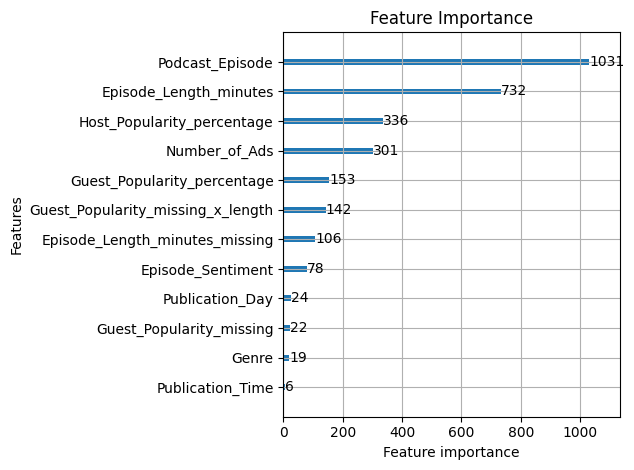

In [112]:
import lightgbm as lgb
import matplotlib.pyplot as plt

lgb.plot_importance(best_model, max_num_features=20)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()



In [79]:
test_1 = pd.read_csv('test.csv')
test_ids = test_1['id']


test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   Podcast_Name                 250000 non-null  object 
 2   Episode_Title                250000 non-null  object 
 3   Episode_Length_minutes       221264 non-null  float64
 4   Genre                        250000 non-null  object 
 5   Host_Popularity_percentage   250000 non-null  float64
 6   Publication_Day              250000 non-null  object 
 7   Publication_Time             250000 non-null  object 
 8   Guest_Popularity_percentage  201168 non-null  float64
 9   Number_of_Ads                250000 non-null  float64
 10  Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


提交区

In [80]:
test_1['Podcast_Episode'] = test_1['Podcast_Name'] + ' - ' + test_1['Episode_Title']
test_1 = test_1.drop('id', axis=1)
test_1 = test_1.drop(['Guest_Popularity_percentage', 'Podcast_Name', 'Episode_Title'], axis=1) 

test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Episode_Length_minutes      221264 non-null  float64
 1   Genre                       250000 non-null  object 
 2   Host_Popularity_percentage  250000 non-null  float64
 3   Publication_Day             250000 non-null  object 
 4   Publication_Time            250000 non-null  object 
 5   Number_of_Ads               250000 non-null  float64
 6   Episode_Sentiment           250000 non-null  object 
 7   Podcast_Episode             250000 non-null  object 
dtypes: float64(3), object(5)
memory usage: 15.3+ MB


In [81]:
categorical_cols = [
    'Podcast_Episode', 'Publication_Time', 'Genre',
    'Publication_Day', 'Episode_Sentiment'
]

for col in categorical_cols:
    test_1[col] = test_1[col].astype('category')
    
test_1['Number_of_Ads'] = test_1['Number_of_Ads'].fillna(test_1['Number_of_Ads'].median())
test_1['Episode_Length_minutes'] = test_1['Episode_Length_minutes'].fillna(test_1['Episode_Length_minutes'].median())

In [82]:
y_pred = best_model.predict(test_1)

ValueError: train and valid dataset categorical_feature do not match.

In [237]:
submission = pd.DataFrame({
    'id': test_ids,
    'Listening_Time_minutes': y_pred
})

#submission.to_csv('submission.csv', index=False)